# Intro to Classifying Structured Data with TensorFlow
This notebook demonstrates classifying structured. The code presented here can become a starting point for a problem you care about. Our goal is to introduce a variety of techniques (especially, feature engineering) rather than to aim for high-accuracy on the  demo dataset we'll explore. 

### Notes
* If you run this notebook multiple times, you'll want to restore it to a clean state. When you run the notebook, the Estimators will write logs and checkpoint files to disk. These will be in a *./graphs* directory in the same folder as this notebook. Delete this to restore to a clean state.


* We'll demonstrate two types of input functions. First, the pre-built Pandas input function, and second, one written using the new [Datasets API](https://www.tensorflow.org/programmers_guide/datasets). At the time of writing (v1.3) the Datasets API is in contrib. When it moves to core (most likely in v1.4) we'll update this notebook.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections

import numpy as np
import pandas as pd

from IPython.display import Image

import tensorflow as tf
print('This code requires TensorFlow v1.3+')
print('You have:', tf.__version__)

This code requires TensorFlow v1.3+
You have: 1.14.0


### About the dataset

Here, we'll work with the [Adult dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/) from the 1990 US Census. Our task is to predict whether an individual has an income over $50,000 / year, based attributes such as their age and occupation. This is a generic problem with a variety of numeric and categorical attributes - which makes it useful for demonstration purposes.

A great way to get to know the dataset is by using [Facets](https://github.com/pair-code/facets) - an open source tool for visualizing and exploring data. At the time of writing, the [online demo](https://pair-code.github.io/facets/) has the Census data preloaded. Try it! In the screenshot below, each dot represents a person, or, a row from the CSV. They're colored by the label we want to predict ('blue' for less than 50k / year, 'red' for more). In the online demo, clicking on a person will show the attributes, or columns from the CSV file, that describe them - such as their age and occuptation.

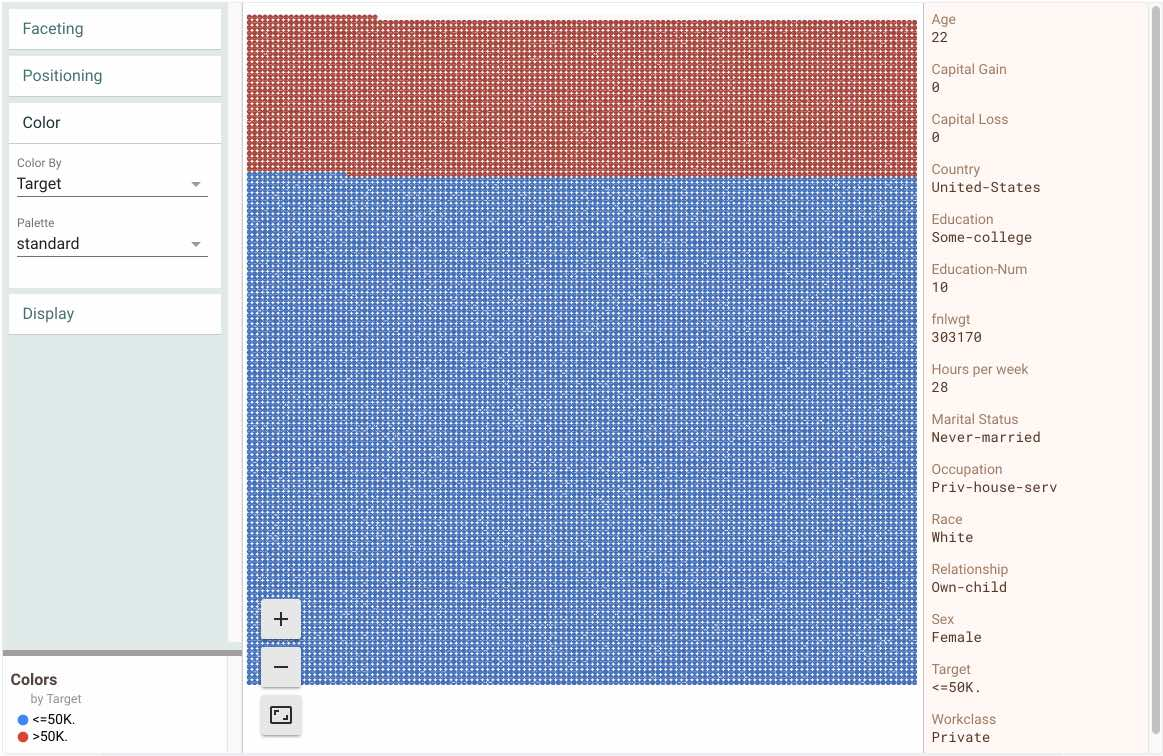

In [2]:
Image(filename='./images/facets1.jpg', width=500)

In [10]:
census_train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
census_test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
census_train_path = tf.contrib.keras.utils.get_file('census.train', census_train_url)
census_test_path = tf.contrib.keras.utils.get_file('census.test', census_test_url)

2007040/2003153 [==============================] - 3s 2us/step


The dataset is missing a header, so we'll add one here. You can find descriptions of these columns in the [names file](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names).

In [9]:
column_names = [
  'age', 'workclass', 'fnlwgt', 'education', 'education-num',
  'marital-status', 'occupation', 'relationship', 'race', 'gender',
  'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
  'income'
]

### Load the using Pandas

In the first half of this notebook, we'll assume the dataset fits into memory. Should you need to work with larger files, you can use the Datasets API to read them.

In [ ]:
# Notes
# 1) We provide the header from above.
# 2) The test file has a line we want to disgard at the top, so we include the parameter 'skiprows=1'
census_train = pd.read_csv(census_train_path, index_col=False, names=column_names) 
census_test = pd.read_csv(census_test_path, skiprows=1, index_col=False, names=column_names) 

# Drop any rows that have missing elements
# Of course there are other ways to handle missing data, but we'll
# take the simplest approach here.
census_train = census_train.dropna(how="any", axis=0)
census_test = census_test.dropna(how="any", axis=0)

### Correct formatting problems with the Census data
As it happens, there's a small formatting problem with the testing CSV file that we'll fix here. The labels in the testing file are written differently than they are in the training file. Notice the extra "." after "<=50K" and ">50K" in the screenshot below.

You can open the CSVs in your favorite text editor to see the error, or you can see it with Facets in "overview mode" - which makes it easy to catch this kind of mistake early.

In [ ]:
Image(filename='./images/facets2.jpg', width=500)

In [ ]:
# Separate the label we want to predict into its own object 
# At the same time, we'll convert it into true/false to fix the formatting error
census_train_label = census_train.pop('income').apply(lambda x: ">50K" in x)
census_test_label = census_test.pop('income').apply(lambda x: ">50K" in x)

I find it useful to print out the shape of the data as I go, as a sanity check.

In [ ]:
print ("Training examples: %d" % census_train.shape[0])
print ("Training labels: %d" % census_train_label.shape[0])
print()
print ("Test examples: %d" % census_test.shape[0])
print ("Test labels: %d" % census_test_label.shape[0])

Likewise, I like to see the head of each file, to help spot errors early on. First for the training examples...

In [ ]:
census_train.head()

... and now for the labels. Notice the label column is now true/false.

In [ ]:
census_train_label.head(10)

In [ ]:
# Likewise, you could do a spot check of the testing examples and labels.
# census_test.head()
# census_test_label.head()

# Estimators and Input Functions

[TensorFlow Estimators](https://www.tensorflow.org/get_started/estimator) provide a high-level API you can use to train your models. Here, we'll use Canned Estimators ("models-in-a-box"). These handle many implementation details for you, so you can focus on solving your problem (e.g., by coming up with informative features using the feature engineering techniques we introduce below). 

To learn more about Estimators, you can watch this talk from Google I/O by Martin Wicke: [Effective TensorFlow for Non-Experts](https://www.youtube.com/watch?v=5DknTFbcGVM). Here's a diagram of the methods we'll use here.

In [ ]:
Image(filename='./images/estimators1.jpeg', width=400)

You can probably guess the purpose of methods like train / evaluate / and predict. What may be new to you, though, are [Input Functions](https://www.tensorflow.org/get_started/estimator#describe_the_training_input_pipeline). These are responsible for reading your data, preprocessing it, and sending it to the model. When you use an input function, your code will read *estimator.train(your_input_function)* rather than *estimator.train(your_training_data)*. 

First, we'll use a [pre-built](https://www.tensorflow.org/get_started/input_fn) input function. This is useful for working with a Pandas dataset that you happen to already have in memory, as we do here. Next, we'll use the [Datasets API](https://www.tensorflow.org/programmers_guide/datasets) to write our own. The Datasets API will become the standard way of writing input functions moving forward. It's in contrib in TensorFlow v1.3, but will most likely move to core in v1.4.

### Input functions for training and testing data
Why do we need two input functions? There are a couple differences in how we handle our training and testing data. We want the training input function to loop over the data indefinitely (returning batches of examples and labels when called). We want the testing input function run for just one epoch, so we can make one prediction for each testing example. We'll also want to shuffle the training data, but not the testing data (so we can compare it to the labels later).

In [ ]:
def create_train_input_fn(): 
    return tf.estimator.inputs.pandas_input_fn(
        x=census_train,
        y=census_train_label, 
        batch_size=32,
        num_epochs=None, # Repeat forever
        shuffle=True)

In [ ]:
def create_test_input_fn():
    return tf.estimator.inputs.pandas_input_fn(
        x=census_test,
        y=census_test_label, 
        num_epochs=1, # Just one epoch
        shuffle=False) # Don't shuffle so we can compare to census_test_labels later

See the bottom of the notebook for an example of doing this with the new Datasets API.

# Feature Engineering

Now we'll specify the features we'll use and how we'd like them represented. To do so, we'll use tf.feature_columns. Basically, these enable you to represent a column from the CSV file in a variety of interesting ways. Our goal here is to demostrate how to work with different types of features, rather than to aim for an accurate model. Here are five different types we'll use in our Linear model:

* A numeric_column. This is just a real-valued attribute.
* A bucketized_column. TensorFlow automatically buckets a numeric column for us.
* A categorical_column_with_vocabulary_list. This is just a categorical column, where you know the possible values in advance. This is useful when you have a small number of possibilities.
* A categorical_column_with_hash_bucket. This is a useful way to represent categorical features when you have a large number of values. Beware of hash collisions.
* A crossed_column. Linear models cannot consider interactions between features, so we'll ask TensorFlow to cross features for us.

In the Deep model, we'll also use:

* An embedding column(!). This automatically creates an embedding for categorical data.

You can learn more about feature columns in the [Large Scale Linear Models Tutorial](https://www.tensorflow.org/tutorials/linear#feature_columns_and_transformations) in the [Wide & Deep tutorial](https://www.tensorflow.org/tutorials/wide_and_deep#define_base_feature_columns), as well as in the [API doc](https://www.tensorflow.org/api_docs/python/tf/feature_column). 

Following is a demo of a couple of the things you can do.

In [ ]:
# A list of the feature columns we'll use to train the Linear model
feature_columns = []

In [ ]:
# To start, we'll use the raw, numeric value of age.
age = tf.feature_column.numeric_column('age')
feature_columns.append(age)

Next, we'll add a bucketized column. Bucketing divides the data based on ranges, so the classifier can consider each independently. This is especially helpful to linear models. Here's what the buckets below look like for age, as seen using Facets.

In [ ]:
Image(filename='./images/buckets.jpeg', width=400)

In [ ]:
age_buckets = tf.feature_column.bucketized_column(
    tf.feature_column.numeric_column('age'), 
    boundaries=[31, 46, 60, 75, 90] # specify the ranges
)

feature_columns.append(age_buckets)

You can also evenly divide the data, if you prefer not to specify the ranges yourself.

In [ ]:
# age_buckets = tf.feature_column.bucketized_column(
#    tf.feature_column.numeric_column('age'), 
#    list(range(10))
#)

In [ ]:
# Here's a categorical column
# We're specifying the possible values
education = tf.feature_column.categorical_column_with_vocabulary_list(
    "education", [
        "Bachelors", "HS-grad", "11th", "Masters", "9th",
        "Some-college", "Assoc-acdm", "Assoc-voc", "7th-8th",
        "Doctorate", "Prof-school", "5th-6th", "10th", "1st-4th",
        "Preschool", "12th"
    ])

feature_columns.append(education)

If you prefer not to specify the vocab in code, you can also read it from a file, or alternatively - use a categorical_column_with_hash_bucket. Beware of hash collisions.

In [ ]:
# A categorical feature with a possibly large number of values
# and the vocabulary not specified in advance.
native_country = tf.feature_column.categorical_column_with_hash_bucket('native-country', 1000)
feature_columns.append(native_country)

Now let's create a crossed column for age and education. Here's what this looks like.

In [ ]:
Image(filename='./images/crossed.jpeg', width=400)

In [ ]:
age_cross_education = tf.feature_column.crossed_column(
    [age_buckets, education],
    hash_bucket_size=int(1e4) # Using a hash is handy here
)
feature_columns.append(age_cross_education)

## Train a Canned Linear Estimator

Note: logs and a checkpoint file will be written to *model_dir*. Delete this from disk before rerunning the notebook for a clean start.

In [ ]:
train_input_fn = create_train_input_fn()
estimator = tf.estimator.LinearClassifier(feature_columns, model_dir='graphs/linear', n_classes=2)
estimator.train(train_input_fn, steps=1000)

## Evaluate

In [ ]:
test_input_fn = create_test_input_fn()
estimator.evaluate(test_input_fn)

### Predict

The Estimator returns a generator object. This bit of code demonstrates how to retrieve predictions for individual examples.

In [ ]:
# reinitialize the input function
test_input_fn = create_test_input_fn()

predictions = estimator.predict(test_input_fn)
i = 0
for prediction in predictions:
    true_label = census_test_label[i]
    predicted_label = prediction['class_ids'][0]
    # Uncomment the following line to see probabilities for individual classes
    # print(prediction) 
    print("Example %d. Actual: %d, Predicted: %d" % (i, true_label, predicted_label))
    i += 1
    if i == 5: break

## What features can you use to achieve higher accuracy?
This dataset is imbalanced, so an an accuracy of around 75% is *low* in this context (this could be achieved merely by predicting *everyone* makes less than 50k / year). In fact, if you look through the predictions closely, you'll find that many are zero. We'll get a little smarter as we go.

## Train a Deep Model

### Add an embedding feature(!) and update the feature columns
Instead of using a hash to represent categorical features, here we'll use a learned embedding. (Cool, right?) We'll also update how the features are represented for our deep model. Here, we'll use a different combination of features that before, just for fun.

In [ ]:
# We'll provide vocabulary lists for features with just a few terms
workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    'workclass',
    [' Self-emp-not-inc', ' Private', ' State-gov', ' Federal-gov',
     ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay', ' Never-worked'])

education = tf.feature_column.categorical_column_with_vocabulary_list(
    'education',
    [' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th', ' Some-college',
     ' Assoc-acdm', ' Assoc-voc', ' 7th-8th', ' Doctorate', ' Prof-school',
     ' 5th-6th', ' 10th', ' 1st-4th', ' Preschool', ' 12th'])

marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    'marital-status',
    [' Married-civ-spouse', ' Divorced', ' Married-spouse-absent',
     ' Never-married', ' Separated', ' Married-AF-spouse', ' Widowed'])
     
relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    'relationship',
    [' Husband', ' Not-in-family', ' Wife', ' Own-child', ' Unmarried',
     ' Other-relative'])

In [ ]:
feature_columns = [

    # Use indicator columns for low dimensional vocabularies
    tf.feature_column.indicator_column(workclass),
    tf.feature_column.indicator_column(education),
    tf.feature_column.indicator_column(marital_status),
    tf.feature_column.indicator_column(relationship),

    # Use embedding columns for high dimensional vocabularies
    tf.feature_column.embedding_column(  # now using embedding!
        # params are hash buckets, embedding size
        tf.feature_column.categorical_column_with_hash_bucket('occupation', 100), 10),
    
    # numeric features
    tf.feature_column.numeric_column('age'),
    tf.feature_column.numeric_column('education-num'),
    tf.feature_column.numeric_column('capital-gain'),
    tf.feature_column.numeric_column('capital-loss'),
    tf.feature_column.numeric_column('hours-per-week'),   
]

In [ ]:
estimator = tf.estimator.DNNClassifier(hidden_units=[256, 128, 64], 
                                       feature_columns=feature_columns, 
                                       n_classes=2, 
                                       model_dir='graphs/dnn')

In [ ]:
train_input_fn = create_train_input_fn()
estimator.train(train_input_fn, steps=2000)

In [ ]:
test_input_fn = create_test_input_fn()
estimator.evaluate(test_input_fn)

That's a little better.

### TensorBoard
If you like, you can start TensorBoard by running this from a terminal command (in the same directory as this notebook):

```$ tensorboard --logdir=graphs```

then pointing your web-browser to ```http://localhost:6006``` (check the TensorBoard output in the terminal in case it's running on a different port).

When that launches, you'll be able to see a variety of graphs that compares the linear and deep models.

In [ ]:
Image(filename='./images/tensorboard.jpeg', width=500)

## Datasets API
Here, I'll demonstrate how to use the new [Datasets API](https://www.tensorflow.org/programmers_guide/datasets), which you can use to write complex input pipeline from simple, reusable pieces. 

At the time of writing (v1.3) this API is in contrib. It's most likely moving into core in v1.4, which is good news. Using TensorFlow 1.4, the below can be written using *regular* Python code to parse the CSV file, via the *Datasets.from_generator()* method. This improves producivity a lot - it means you can use Python to read, parse, and apply whatever logic you wish to your input data - then you can take advantage of the reusable pieces of the Datasets API (e.g., batch, shuffle, repeat, etc) - as well as the optional performance tuning (e.g., prefetch, parallel process, etc).

In combination with Estimators, this means you can train and tune deep models at scale on data of almost any size, entirely using a high-level API. I'll update this notebook after v1.4 is released with an example. It's neat. 

In [ ]:
# I'm going to reset the notebook to show you how to do this from a clean slate
%reset -f 

import collections
import tensorflow as tf

census_train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
census_test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
census_train_path = tf.contrib.keras.utils.get_file('census.train', census_train_url)
census_test_path = tf.contrib.keras.utils.get_file('census.test', census_test_url)

In [ ]:
# Provide default values for each of the CSV columns
# and a header at the same time.
csv_defaults = collections.OrderedDict([
  ('age',[0]),
  ('workclass',['']),
  ('fnlwgt',[0]),
  ('education',['']),
  ('education-num',[0]),
  ('marital-status',['']),
  ('occupation',['']),
  ('relationship',['']),
  ('race',['']),
  ('sex',['']),
  ('capital-gain',[0]),
  ('capital-loss',[0]),
  ('hours-per-week',[0]),
  ('native-country',['']),
  ('income',['']),
])

In [ ]:
# Decode a line from the CSV.
def csv_decoder(line):
    """Convert a CSV row to a dictonary of features."""
    parsed = tf.decode_csv(line, list(csv_defaults.values()))
    return dict(zip(csv_defaults.keys(), parsed))

# The train file has an extra empty line at the end.
# We'll use this method to filter that out.
def filter_empty_lines(line):
    return tf.not_equal(tf.size(tf.string_split([line], ',').values), 0)

def create_train_input_fn(path):
    def input_fn():    
        dataset = (
            tf.contrib.data.TextLineDataset(path)  # create a dataset from a file
                .filter(filter_empty_lines)  # ignore empty lines
                .map(csv_decoder)  # parse each row
                .shuffle(buffer_size=1000)  # shuffle the dataset
                .repeat()  # repeate indefinitely
                .batch(32)) # batch the data

        # create iterator
        columns = dataset.make_one_shot_iterator().get_next()
        
        # separate the label and convert it to true/false
        income = tf.equal(columns.pop('income')," >50K") 
        return columns, income
    return input_fn

def create_test_input_fn(path):
    def input_fn():    
        dataset = (
            tf.contrib.data.TextLineDataset(path)
                .skip(1) # The test file has a strange first line, we want to ignore this.
                .filter(filter_empty_lines)
                .map(csv_decoder)
                .batch(32))

        # create iterator
        columns = dataset.make_one_shot_iterator().get_next()
        
        # separate the label and convert it to true/false
        income = tf.equal(columns.pop('income')," >50K") 
        return columns, income
    return input_fn

## Here's code you can use test the Dataset input functions

In [ ]:
train_input_fn = create_train_input_fn(census_train_path)
next_batch = train_input_fn()

with tf.Session() as sess:
    features, label = sess.run(next_batch)
    print(features['education'])
    print(label)

    print()

    features, label = sess.run(next_batch)
    print(features['education'])
    print(label)

From here, you can use the input functions to train and evaluate your Estimators. I'll add some minimal code to do this, just to show the mechanics.

In [ ]:
train_input_fn = create_train_input_fn(census_train_path)
test_input_fn = create_train_input_fn(census_test_path)

feature_columns = [
    tf.feature_column.numeric_column('age'),
]

estimator = tf.estimator.DNNClassifier(hidden_units=[256, 128, 64], 
                                       feature_columns=feature_columns, 
                                       n_classes=2, 
                                       # creating a new folder in case you haven't cleared 
                                       # the old one yet
                                       model_dir='graphs_datasets/dnn')

estimator.train(train_input_fn, steps=100)
estimator.evaluate(train_input_fn, steps=100)

This would be a good time to clean up the logs and checkpoints on disk, by deleting ```./graphs``` and ```./graphs_datasets```.

## Next steps

## To learn more about feature engineering

Check out the [Wide and Deep tutorial](https://www.tensorflow.org/tutorials/wide_and_deep). Also, see that tutorial for another kind of Estimator you can try that combines the Linear and Deep models.

## To learn more about Datasets

Check out the [programmers guide](https://www.tensorflow.org/programmers_guide/datasets), and check back after v1.4 is released for the Dataset.from_generator method, which I think will improve productivity a lot.